In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks, welch
import pandas as pd

raw = pd.read_csv('ekgp4.csv')  # raw data from ekg
sampling_rate = 1000  # sampling rate (Hz)

print(raw.head())

   Data Set 3:Time(s)  Data Set 3:Potential(mV)  Data Set 3:EKG(mV)
0               0.000                 -0.047928           -0.002211
1               0.005                 -0.046707           -0.009467
2               0.010                  0.049881           -0.015508
3               0.015                  0.061325           -0.010341
4               0.020                  0.051102            0.004425


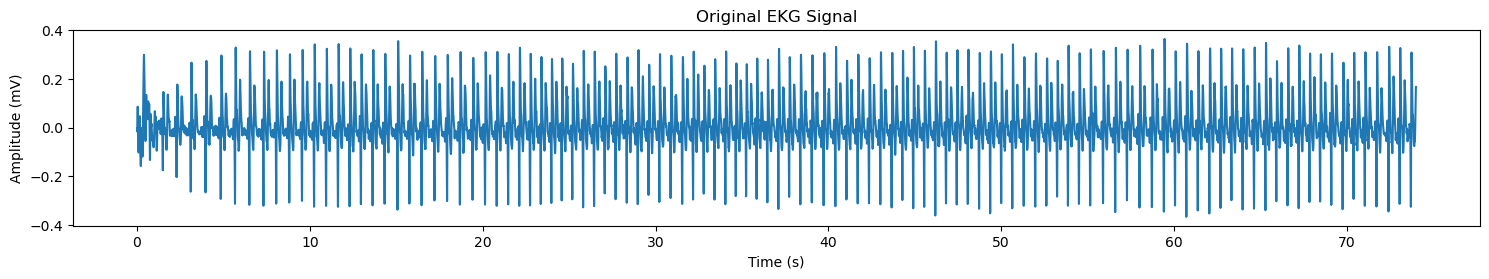

In [49]:
#| label: raw
{
    "trusted": True,
    "editable": True,
    "tags": [],
    "label": "raw"
}
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')

    # Ensure signal length is good
    if len(signal) > 27:
        return filtfilt(b, a, signal)
    else:
        raise ValueError("Signal is too short for filtering. Check your input signal length.")

ekg = raw['Data Set 3:EKG(mV)'].values  # Extract only the EKG column as a numpy array
time = raw['Data Set 3:Time(s)']
# Filter
try:
    filtered = bandpass_filter(ekg, 0.5, 150, sampling_rate)
except ValueError as e:
    print("Error during filtering:", e)

# Plots original v filtered 
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.plot(raw['Data Set 3:Time(s)'], ekg)
plt.title('Original EKG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')

plt.tight_layout()
plt.show()


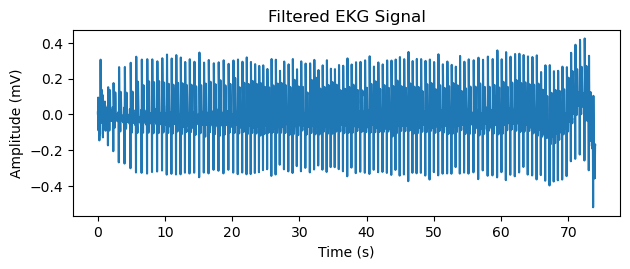

In [50]:
#| label: filtered
{
    "trusted": True,
    "editable": True,
    "tags": [],
    "label": "filtered"
}
plt.subplot(2, 1, 2)
plt.plot(raw['Data Set 3:Time(s)'], filtered)
plt.title('Filtered EKG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.tight_layout()
plt.show()

In [51]:
def detect_r_peaks(signal, sampling_rate, min_distance=0.6, prominence=0.5):
    distance = sampling_rate * min_distance  # min distance between peaks
    peaks, _ = find_peaks(signal, distance=distance, prominence=prominence)
    return peaks
peaks = detect_r_peaks(filtered, sampling_rate)
resp_modulation = bandpass_filter(ekg, 0.1, 0.5, sampling_rate)


In [53]:
intervals = np.diff(peaks) / sampling_rate  # time between peaks in seconds
fs_intervals = 1.0 / np.mean(intervals)  # sampling frequency for intervals

freqs, psd = welch(intervals, fs=fs_intervals, nperseg=16)

def estimate_respiration_rate(intervals):
    fs = 1.0 / np.mean(intervals)  # sampling frequency based on mean RR interval
    freq, psd = welch(intervals, fs=fs, nperseg=16)
    respiratory_freq = freq[(freq >= 0.15) & (freq <= 0.4)]  # respiratory band
    respiratory_power = psd[(freq >= 0.15) & (freq <= 0.4)]
    peak_freq = respiratory_freq[np.argmax(respiratory_power)]
    return peak_freq * 60  # Hz to breaths per minute

respiratory_rate = estimate_respiration_rate(intervals)
print(f"Respiratory Rate: {respiratory_rate:.2f} breaths/min")

Respiratory Rate: 22.48 breaths/min


In [54]:
filtered

array([ 0.01098873,  0.00235841, -0.00176087, ..., -0.1695423 ,
       -0.16666954, -0.16853449], shape=(14801,))

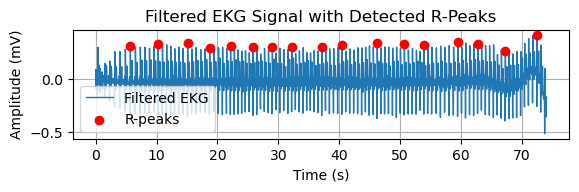

In [55]:
#| label: rpeaks
{
    "trusted": True,
    "editable": True,
    "tags": [],
    "label": "rpeaks"
}
# plot filtered EKG with R-peaks
plt.subplot(3, 1, 1)
plt.plot(time, filtered, label='Filtered EKG', linewidth=1)
plt.scatter(time[peaks], filtered[peaks], color='red', label='R-peaks', zorder=5)
plt.title('Filtered EKG Signal with Detected R-Peaks')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.legend()
plt.grid(True)

/Users/alexanderdickens/miniforge3/envs/jterm2025/lib/python3.13/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 16, using nperseg = 16
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


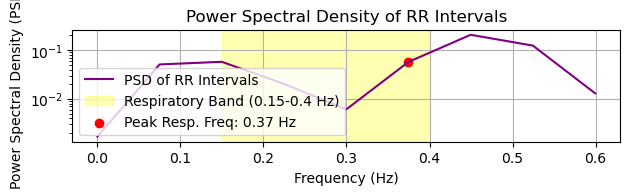

In [56]:
# Power Spectral Density (PSD)  intervals to estimate respiratory rate
fs_intervals = 1.0 / np.mean(intervals)  # sampling frequency for intervals
freqs, psd = welch(intervals, fs=fs_intervals, nperseg=256)

# highlight respiratory band
resp_band = (freqs >= 0.15) & (freqs <= 0.4)
peak_freq = freqs[resp_band][np.argmax(psd[resp_band])]

# plot PSD with respiratory band
plt.subplot(3, 1, 3)
plt.semilogy(freqs, psd, label='PSD of RR Intervals', color='purple')
plt.axvspan(0.15, 0.4, color='yellow', alpha=0.3, label='Respiratory Band (0.15-0.4 Hz)')
plt.scatter(peak_freq, psd[resp_band].max(), color='red', label=f'Peak Resp. Freq: {peak_freq:.2f} Hz')
plt.title('Power Spectral Density of RR Intervals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (PSD)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()